In [6]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [7]:
import numpy as np
import pandas as pd
from collections import defaultdict

In [8]:
import warnings 

warnings.filterwarnings('ignore')

# <center>Computational Mathematics Report Experiments</center>
## <center>Support Vector Classifier</center>
### <center>Donato Meoli</center>
##### <center>d.meoli@studenti.unipi.it</center>

<center>Computational Mathematics course 646AA</center>
<center>Academic year: 2019/2020</center>

<center>Type of project: Wildcard #5 with Machine Learning</center>
<center>Group 35</center>

In [9]:
def filter_svc_cv_results(cv_results):
    
    filtered_cv_results = pd.DataFrame()
    
    if 'param_optimizer' in cv_results.columns:
        
        filtered_cv_results['solver'] = cv_results['param_optimizer']
    
    if 'param_fit_intercept' in cv_results.columns:
        
        filtered_cv_results['dual'] = cv_results['param_fit_intercept']
        filtered_cv_results['dual'] = filtered_cv_results['dual'].replace(True, 'qp')
        filtered_cv_results['dual'] = filtered_cv_results['dual'].replace(False, 'bcqp')
    
    if 'param_kernel' in cv_results.columns:
        
        filtered_cv_results['kernel'] = cv_results['param_kernel']
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*PolyKernel.*$)', 'poly')
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*GaussianKernel.*$)', 'rbf')
    
    filtered_cv_results[['C', 'fit_time', 'accuracy', 'n_iter']] = cv_results[[
        'param_C', 'mean_fit_time', 'mean_train_accuracy', 'mean_train_n_iter']]
    
    filtered_cv_results['n_iter'] = filtered_cv_results['n_iter'].round().astype(int)

    filtered_cv_results['n_sv'] = cv_results['mean_train_n_sv'].round().astype(int)

    return filtered_cv_results

In [10]:
from optiml.ml.utils import generate_linearly_separable_overlap_data, generate_nonlinearly_separable_data

lin_X, lin_y = generate_linearly_separable_overlap_data()
nonlin_X, nonlin_y = generate_nonlinearly_separable_data()

## Hinge loss

### Primal formulation

In [13]:
from optiml.ml.svm import PrimalSVC
from optiml.ml.svm.losses import hinge
from optiml.ml.utils import plot_svm_hyperplane, plot_model_loss

from optiml.opti.unconstrained.stochastic import StochasticGradientDescent
from optiml.opti.utils import plot_surface_contour, plot_trajectory_optimization

from sklearn.svm import LinearSVC as SkLinearSVC
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [14]:
train_loss_history = defaultdict(dict)

def primal_accuracy_scorer(svc, X, y):
    if hasattr(svc, 'train_loss_history'):
        train_loss_history[svc.momentum_type][svc.C] = svc.train_loss_history
    return {'accuracy': svc.score(X, y), 
            'n_iter': svc.n_iter_ if isinstance(svc, SkLinearSVC) else svc.optimizer.epoch + 1,  # starts from 0
            'n_sv': len(np.argwhere(np.abs(svc.decision_function(X)) <= 1).ravel())}

Fitting 1 folds for each of 3 candidates, totalling 3 fits


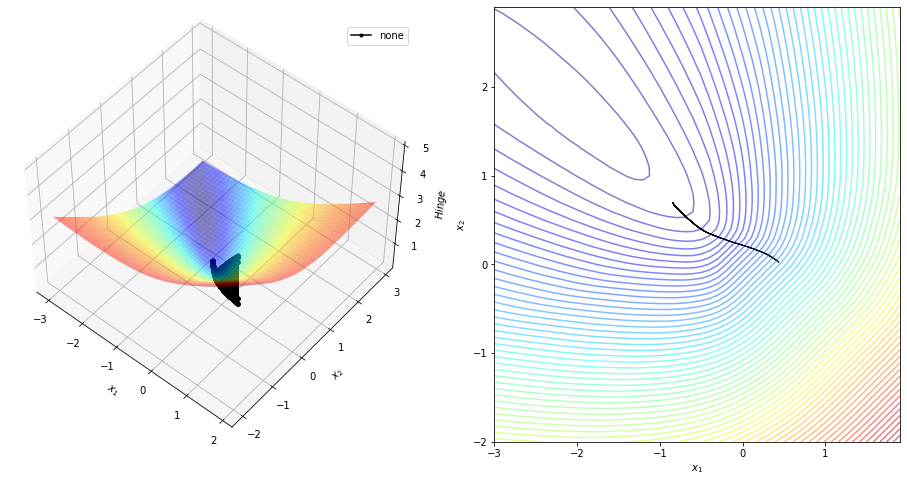

In [15]:
grid = GridSearchCV(PrimalSVC(loss=hinge, optimizer=StochasticGradientDescent, learning_rate=0.001, 
                              momentum_type='none', batch_size=20, early_stopping=True, random_state=2),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

hinge_loss = plot_surface_contour(grid.best_estimator_.loss, x_min=-3, x_max=2, y_min=-2, y_max=3)
hinge_loss_opt = plot_trajectory_optimization(hinge_loss, grid.best_estimator_.optimizer, color='k', label='none')

In [16]:
none_primal_svc_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
none_primal_svc_hinge_cv_results.insert(0, 'solver', 'sgd')
none_primal_svc_hinge_cv_results.insert(1, 'momentum', 'none')
none_primal_svc_hinge_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
none_primal_svc_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                    
sgd    none     1    0.487395      0.99     334    51
                10   0.454088      0.99     359    19
                100  0.118898      0.99      88    12

Fitting 1 folds for each of 3 candidates, totalling 3 fits


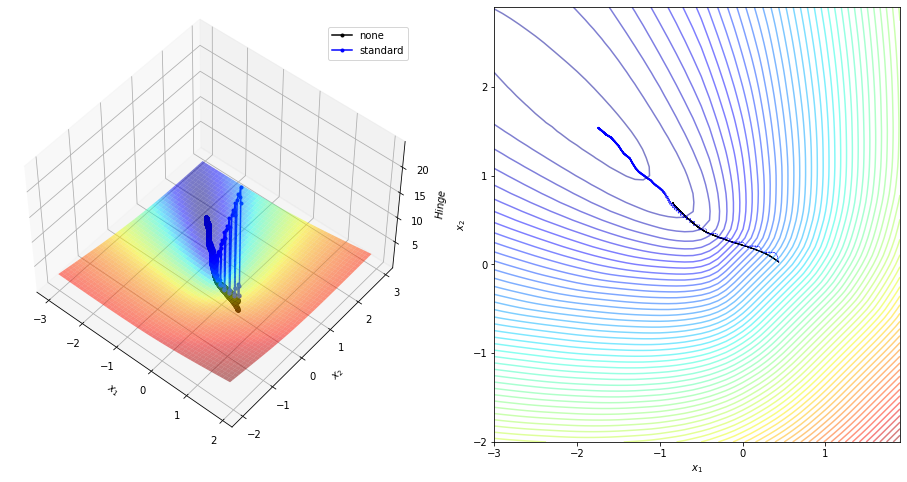

In [17]:
grid = GridSearchCV(PrimalSVC(loss=hinge, optimizer=StochasticGradientDescent, learning_rate=0.001, momentum=0.4, 
                              momentum_type='standard', batch_size=20, early_stopping=True, random_state=2),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

hinge_loss_opt = plot_trajectory_optimization(hinge_loss_opt, grid.best_estimator_.optimizer, 
                                              color='b', label='standard')
hinge_loss_opt

In [18]:
standard_primal_svc_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
standard_primal_svc_hinge_cv_results.insert(0, 'solver', 'sgd')
standard_primal_svc_hinge_cv_results.insert(1, 'momentum', 'standard')
standard_primal_svc_hinge_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
standard_primal_svc_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                    
sgd    standard 1    0.371582     0.990     247    47
                10   0.484645     0.995     361    16
                100  0.080916     0.990      59    12

Fitting 1 folds for each of 3 candidates, totalling 3 fits


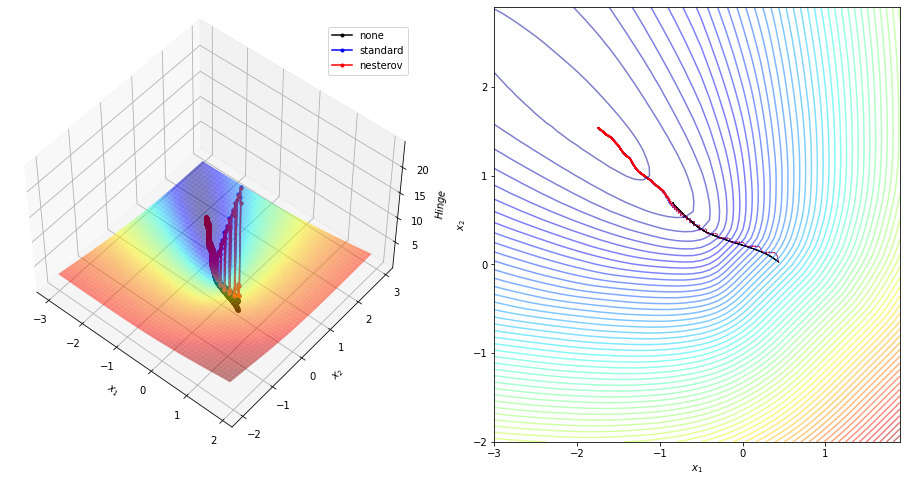

In [19]:
grid = GridSearchCV(PrimalSVC(loss=hinge, optimizer=StochasticGradientDescent, learning_rate=0.001, momentum=0.4, 
                              momentum_type='nesterov', batch_size=20, early_stopping=True, random_state=2),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

hinge_loss_opt = plot_trajectory_optimization(hinge_loss_opt, grid.best_estimator_.optimizer, 
                                              color='r', label='nesterov')
hinge_loss_opt.savefig('./tex/img/svc_hinge_loss.png')
hinge_loss_opt

In [20]:
nesterov_primal_svc_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
nesterov_primal_svc_hinge_cv_results.insert(0, 'solver', 'sgd')
nesterov_primal_svc_hinge_cv_results.insert(1, 'momentum', 'nesterov')
nesterov_primal_svc_hinge_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
nesterov_primal_svc_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                    
sgd    nesterov 1    0.345012     0.990     247    47
                10   0.477134     0.995     360    16
                100  0.072453     0.990      53    12

In [21]:
custom_primal_svc_hinge_cv_results = none_primal_svc_hinge_cv_results.append(
    standard_primal_svc_hinge_cv_results).append(
    nesterov_primal_svc_hinge_cv_results)
custom_primal_svc_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                    
sgd    none     1    0.487395     0.990     334    51
                10   0.454088     0.990     359    19
                100  0.118898     0.990      88    12
       standard 1    0.371582     0.990     247    47
                10   0.484645     0.995     361    16
                100  0.080916     0.990      59    12
       nesterov 1    0.345012     0.990     247    47
                10   0.477134     0.995     360    16
                100  0.072453     0.990      53    12

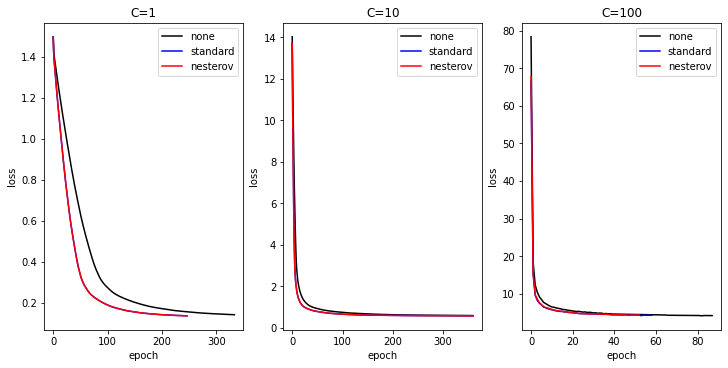

In [23]:
colors = {'none': 'k',
          'standard': 'b',
          'nesterov': 'r'}
axes = plt.figure(figsize=(10, 5), constrained_layout=True).subplots(1, 3)
for momentum, _dict in train_loss_history.items():
    for (C, history), loss in zip(_dict.items(), axes):
        loss.plot(history, color=colors[momentum])
        loss.set_title('C={:d}'.format(C))
        loss.set_xlabel('epoch')
        loss.set_ylabel('loss')
        loss.legend(colors.keys()).get_frame().set_facecolor('white')
plt.savefig('./tex/img/svc_hinge_loss_history.png')

In [87]:
grid = GridSearchCV(SkLinearSVC(loss='hinge', random_state=2),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

Fitting 1 folds for each of 3 candidates, totalling 3 fits


In [40]:
liblinear_primal_svc_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_svc_hinge_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_svc_hinge_cv_results.insert(1, 'momentum', '-')
liblinear_primal_svc_hinge_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
liblinear_primal_svc_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver    momentum C                                    
liblinear -        1    0.001512     0.970     221    16
                   10   0.001837     0.970    1000    13
                   100  0.002751     0.975    1000    12

In [41]:
primal_svc_hinge_cv_results = custom_primal_svc_hinge_cv_results.append(liblinear_primal_svc_hinge_cv_results)
primal_svc_hinge_cv_results.to_latex('./tex/experiments/primal_svc_hinge.tex', 
                                     caption='SVC Primal formulation results with Hinge loss', 
                                     label='primal_svc_hinge_cv_results', position='H')
primal_svc_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver    momentum C                                    
sgd       none     1    0.519958     0.965     291    50
                   10   0.589300     0.970     328    19
                   100  0.084209     0.975      51    17
          standard 1    0.667757     0.970     213    45
                   10   0.581267     0.970     204    19
                   100  0.323588     0.970      52    15
          nesterov 1    0.353313     0.970     213    45
                   10   0.544228     0.970     197    19
                   100  0.087562     0.970      51    16
liblinear -        1    0.001512     0.970     221    16
                   10   0.001837     0.970    1000    13
                   100  0.002751     0.975    1000    12

### Dual formulations

In [42]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.kernels import linear, PolyKernel, GaussianKernel
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [43]:
import re
from io import StringIO
from wurlitzer import pipes, STDOUT


class SklSVC(SVC):

    def fit(self, X, y, sample_weight=None):
        out = StringIO()
        with pipes(stdout=out, stderr=STDOUT):
            super().fit(X, y, sample_weight)
        self.n_iter_ = int(re.findall(r'%s(\d+)' % '#iter = ', out.getvalue())[0])
        return self

In [44]:
def dual_accuracy_scorer(svc, X, y):
    return {'accuracy': svc.score(X, y), 
            'n_iter': svc.n_iter_ if isinstance(svc, SklSVC) else (svc.iter if isinstance(svc.optimizer, str) 
                                                                   else svc.optimizer.iter) + 1,  # starts from 0
            'n_sv': len(svc.support_)}

#### Wolfe Dual

##### Linear

Fitting 1 folds for each of 6 candidates, totalling 6 fits


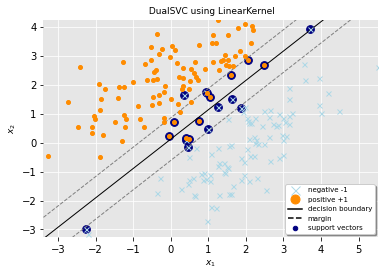

In [45]:
grid = GridSearchCV(DualSVC(kernel=linear),
                    param_grid={'C': [1, 10, 100],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

plot_svm_hyperplane(grid.best_estimator_, lin_X, lin_y)
plt.savefig('./tex/img/linear_dual_svc_hyperplane.png')

In [48]:
custom_linear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
custom_linear_dual_svc_cv_results.sort_values(['solver'], inplace=True)
custom_linear_dual_svc_cv_results.set_index(['solver', 'C'], inplace=True)
custom_linear_dual_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver C                                    
cvxopt 1    0.144664      0.97      10    20
       10   0.162875      0.97      10    16
       100  0.038245      0.97      10    18
smo    1    0.240170      0.97     142    20
       10   2.656202      0.97    6975    16
       100  2.029251      0.97    3601    16

In [49]:
grid = GridSearchCV(SklSVC(kernel='linear', verbose=True),  # `verbose=True` to capture n_iter
                    param_grid={'C': [1, 10, 100]},
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

Fitting 1 folds for each of 3 candidates, totalling 3 fits
[LibSVM]

In [50]:
libsvm_linear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_linear_dual_svc_cv_results.insert(0, 'solver', 'libsvm')
libsvm_linear_dual_svc_cv_results.set_index(['solver', 'C'], inplace=True)
libsvm_linear_dual_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver C                                    
libsvm 1    0.002645      0.97     174    20
       10   0.002526      0.97     448    16
       100  0.003148      0.97    2357    16

In [51]:
linear_dual_svc_cv_results = custom_linear_dual_svc_cv_results.append(libsvm_linear_dual_svc_cv_results)
linear_dual_svc_cv_results.sort_values(['solver'], ascending=False, inplace=True)
linear_dual_svc_cv_results.to_latex('./tex/experiments/linear_dual_svc.tex', 
                                    caption='Linear SVC Wolfe Dual formulation results with Hinge loss', 
                                    label='linear_dual_svc_cv_results', position='H')
linear_dual_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver C                                    
smo    1    0.240170      0.97     142    20
       10   2.656202      0.97    6975    16
       100  2.029251      0.97    3601    16
libsvm 1    0.002645      0.97     174    20
       10   0.002526      0.97     448    16
       100  0.003148      0.97    2357    16
cvxopt 1    0.144664      0.97      10    20
       10   0.162875      0.97      10    16
       100  0.038245      0.97      10    18

##### Nonlinear

Fitting 1 folds for each of 6 candidates, totalling 6 fits


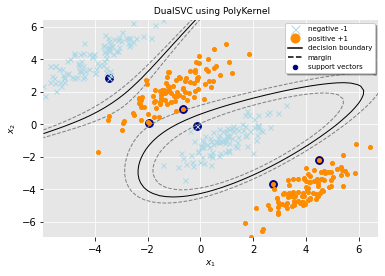

In [52]:
grid = GridSearchCV(DualSVC(),
                    param_grid={'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=1, gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

plot_svm_hyperplane(grid.best_estimator_, nonlin_X, nonlin_y)
plt.savefig('./tex/img/poly_dual_svc_hyperplane.png')

In [55]:
poly_nonlinear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
poly_nonlinear_dual_svc_cv_results.sort_values(['solver'], inplace=True)
poly_nonlinear_dual_svc_cv_results.set_index(['solver', 'kernel', 'C'], inplace=True)
poly_nonlinear_dual_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver kernel C                                    
cvxopt poly   1    0.162190    0.7600      10    35
              10   0.177191    0.7225      10    11
              100  0.268605    1.0000      10     7
smo    poly   1    0.379582    0.7600     189    35
              10   0.247968    0.7200     136    11
              100  0.182547    1.0000      53     7

Fitting 1 folds for each of 6 candidates, totalling 6 fits


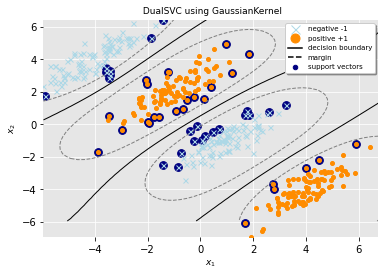

In [56]:
grid = GridSearchCV(DualSVC(),
                    param_grid={'C': [1, 10, 100],
                                'kernel': [GaussianKernel(gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

plot_svm_hyperplane(grid.best_estimator_, nonlin_X, nonlin_y)
plt.savefig('./tex/img/gaussian_dual_svc_hyperplane.png')

In [57]:
rbf_nonlinear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
rbf_nonlinear_dual_svc_cv_results.sort_values(['solver'], inplace=True)
rbf_nonlinear_dual_svc_cv_results.set_index(['solver', 'kernel', 'C'], inplace=True)
rbf_nonlinear_dual_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver kernel C                                    
cvxopt rbf    1    0.204111       1.0      10    53
              10   0.413414       1.0      10    20
              100  0.402257       1.0      10    11
smo    rbf    1    0.256769       1.0      49    49
              10   0.472447       1.0      59    16
              100  0.397661       1.0      34    10

In [58]:
custom_nonlinear_dual_svc_cv_results = poly_nonlinear_dual_svc_cv_results.append(rbf_nonlinear_dual_svc_cv_results)
custom_nonlinear_dual_svc_cv_results.sort_values(['solver', 'kernel'], inplace=True)
custom_nonlinear_dual_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver kernel C                                    
cvxopt poly   1    0.162190    0.7600      10    35
              10   0.177191    0.7225      10    11
              100  0.268605    1.0000      10     7
       rbf    1    0.204111    1.0000      10    53
              10   0.413414    1.0000      10    20
              100  0.402257    1.0000      10    11
smo    poly   1    0.379582    0.7600     189    35
              10   0.247968    0.7200     136    11
              100  0.182547    1.0000      53     7
       rbf    1    0.256769    1.0000      49    49
              10   0.472447    1.0000      59    16
              100  0.397661    1.0000      34    10

In [59]:
grid = GridSearchCV(SklSVC(verbose=True),  # `verbose=True` to capture n_iter
                    param_grid=[{'C': [1, 10, 100],
                                 'kernel': ['poly'],
                                 'degree': [3],
                                 'coef0': [1],
                                 'gamma': ['scale']},
                                {'C': [1, 10, 100],
                                 'kernel': ['rbf'],
                                 'gamma': ['scale']}],
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

Fitting 1 folds for each of 6 candidates, totalling 6 fits
[LibSVM]

In [60]:
libsvm_nonlinear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_nonlinear_dual_svc_cv_results.insert(0, 'solver', 'libsvm')
libsvm_nonlinear_dual_svc_cv_results.sort_values(['kernel'], inplace=True)
libsvm_nonlinear_dual_svc_cv_results.set_index(['solver', 'kernel', 'C'], inplace=True)
libsvm_nonlinear_dual_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver kernel C                                    
libsvm poly   1    0.014780       1.0     469    35
              10   0.013879       1.0     267    11
              100  0.010141       1.0     170     7
       rbf    1    0.011520       1.0      93    48
              10   0.013638       1.0     156    16
              100  0.008230       1.0     120    10

In [61]:
nonlinear_dual_svc_cv_results = custom_nonlinear_dual_svc_cv_results.append(libsvm_nonlinear_dual_svc_cv_results)
nonlinear_dual_svc_cv_results.sort_values(['solver', 'kernel'], ascending=[False, True], inplace=True)
nonlinear_dual_svc_cv_results.to_latex('./tex/experiments/nonlinear_dual_svc.tex', 
                                       caption='Nonlinear SVC Wolfe Dual formulation results with Hinge loss', 
                                       label='nonlinear_dual_svc_cv_results', position='H')
nonlinear_dual_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver kernel C                                    
smo    poly   1    0.379582    0.7600     189    35
              10   0.247968    0.7200     136    11
              100  0.182547    1.0000      53     7
       rbf    1    0.256769    1.0000      49    49
              10   0.472447    1.0000      59    16
              100  0.397661    1.0000      34    10
libsvm poly   1    0.014780    1.0000     469    35
              10   0.013879    1.0000     267    11
              100  0.010141    1.0000     170     7
       rbf    1    0.011520    1.0000      93    48
              10   0.013638    1.0000     156    16
              100  0.008230    1.0000     120    10
cvxopt poly   1    0.162190    0.7600      10    35
              10   0.177191    0.7225      10    11
              100  0.268605    1.0000      10     7
       rbf    1    0.204111    1.0000      10    53
              10   0.413414    1.0000      10    20
              100  0.402257    1.0000      10    11

#### Lagrangian Dual

##### Linear

In [86]:
grid = GridSearchCV(DualSVC(kernel=linear, optimizer=AdaGrad, learning_rate=0.001),
                    param_grid={'C': [1, 10, 100],
                                'fit_intercept': [True, False]},
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

Fitting 1 folds for each of 6 candidates, totalling 6 fits


In [87]:
linear_lagrangian_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
linear_lagrangian_dual_svc_cv_results.sort_values(['dual'], ascending=False, inplace=True)
linear_lagrangian_dual_svc_cv_results.set_index(['dual', 'C'], inplace=True)
linear_lagrangian_dual_svc_cv_results.to_latex('./tex/experiments/linear_lagrangian_dual_svc.tex', 
                                               caption='Linear SVC Lagrangian Dual formulation results with Hinge loss', 
                                               label='linear_lagrangian_dual_svc_cv_results', position='H')
linear_lagrangian_dual_svc_cv_results

fit_time  accuracy  n_iter  n_sv
dual C                                    
qp   1    0.028132      0.97       1   194
     10   0.027381      0.97       1   194
     100  0.034051      0.97       1   194
bcqp 1    0.031179      0.97       1   193
     10   0.023645      0.97       1   193
     100  0.028539      0.97       1   193

##### Nonlinear

In [90]:
grid = GridSearchCV(DualSVC(optimizer=AdaGrad, learning_rate=0.001),
                    param_grid={'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=1, gamma='scale'), 
                                           GaussianKernel(gamma='scale')],
                                'fit_intercept': [True, False]},
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

Fitting 1 folds for each of 12 candidates, totalling 12 fits


In [91]:
nonlinear_lagrangian_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
nonlinear_lagrangian_dual_svc_cv_results.sort_values(['dual', 'kernel'], ascending=[False, True], inplace=True)
nonlinear_lagrangian_dual_svc_cv_results.set_index(['dual', 'kernel', 'C'], inplace=True)
nonlinear_lagrangian_dual_svc_cv_results.to_latex('./tex/experiments/nonlinear_lagrangian_dual_svc.tex', 
                                                  caption='Nonlinear SVC Lagrangian Dual formulation results with Hinge loss', 
                                                  label='nonlinear_lagrangian_dual_svc_cv_results', position='H')
nonlinear_lagrangian_dual_svc_cv_results

fit_time  accuracy  n_iter  n_sv
dual kernel C                                    
qp   poly   1    0.083991    0.5900       3   312
            10   0.082520    0.5900       3   312
            100  0.063880    0.5900       3   312
     rbf    1    0.159785    0.7625       7   307
            10   0.215768    0.7625       7   307
            100  0.161169    0.7625       7   307
bcqp poly   1    5.586180    0.5875    1000   312
            10   5.466839    0.5875    1000   312
            100  5.492280    0.5875    1000   312
     rbf    1    0.072574    1.0000       1   398
            10   0.095489    1.0000       1   398
            100  0.035152    1.0000       1   398

## Squared Hinge loss

### Primal formulation

In [26]:
from optiml.ml.svm import PrimalSVC
from optiml.ml.svm.losses import squared_hinge
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import StochasticGradientDescent
from optiml.opti.utils import plot_surface_contour, plot_trajectory_optimization

from sklearn.svm import LinearSVC as SkLinearSVC
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [27]:
train_loss_history = defaultdict(dict)

def primal_accuracy_scorer(svc, X, y):
    if hasattr(svc, 'train_loss_history'):
        train_loss_history[svc.momentum_type][svc.C] = svc.train_loss_history
    return {'accuracy': svc.score(X, y), 
            'n_iter': svc.n_iter_ if isinstance(svc, SkLinearSVC) else svc.optimizer.epoch + 1,  # starts from 0
            'n_sv': len(np.argwhere(np.abs(svc.decision_function(X)) <= 1).ravel())}

Fitting 1 folds for each of 3 candidates, totalling 3 fits


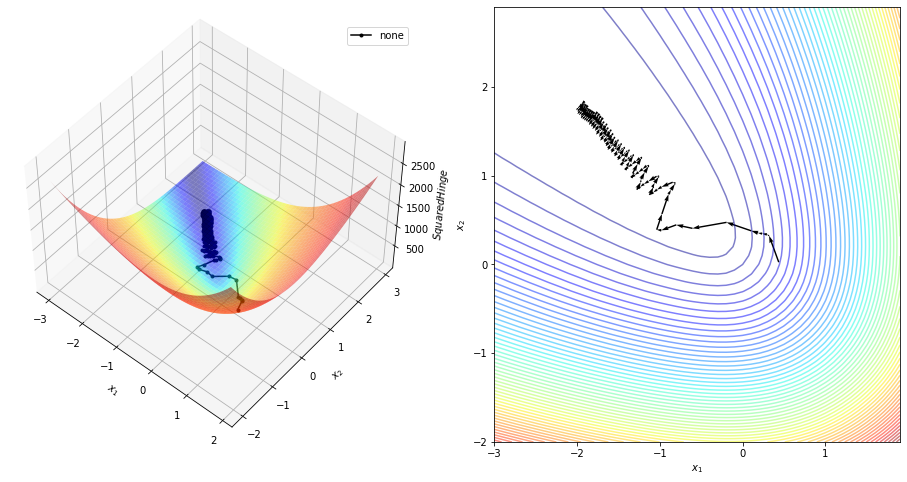

In [28]:
grid = GridSearchCV(PrimalSVC(loss=squared_hinge, optimizer=StochasticGradientDescent, learning_rate=0.001, 
                              momentum_type='none', batch_size=20, early_stopping=True, random_state=2),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

squared_hinge_loss = plot_surface_contour(grid.best_estimator_.loss, x_min=-3, x_max=2, y_min=-2, y_max=3)
squared_hinge_loss_opt = plot_trajectory_optimization(squared_hinge_loss, grid.best_estimator_.optimizer, 
                                                      color='k', label='none')

In [29]:
none_primal_svc_squared_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
none_primal_svc_squared_hinge_cv_results.insert(0, 'solver', 'sgd')
none_primal_svc_squared_hinge_cv_results.insert(1, 'momentum', 'none')
none_primal_svc_squared_hinge_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
none_primal_svc_squared_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                    
sgd    none     1    0.246589     0.990     163    50
                10   0.190085     0.990     139    19
                100  0.041115     0.995      29    14

Fitting 1 folds for each of 3 candidates, totalling 3 fits


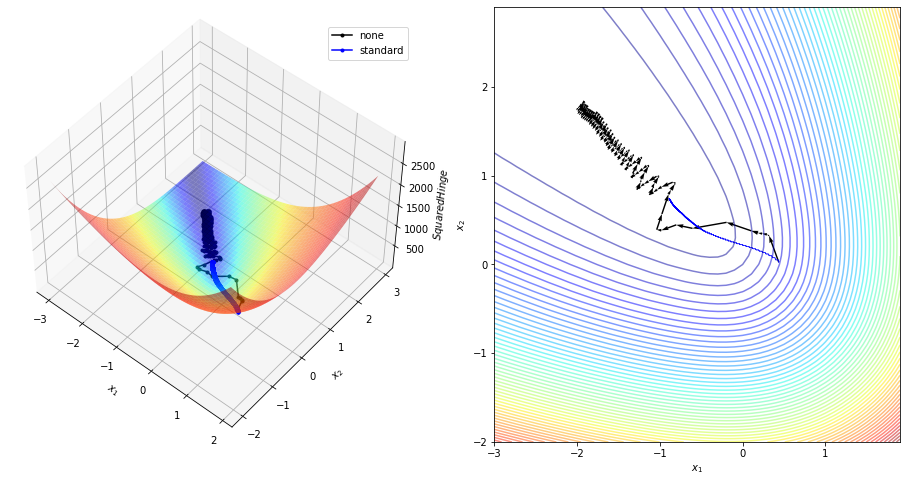

In [30]:
grid = GridSearchCV(PrimalSVC(loss=squared_hinge, optimizer=StochasticGradientDescent, learning_rate=0.001, 
                              momentum_type='standard', momentum=0.4, batch_size=20, early_stopping=True, 
                              random_state=2),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

squared_hinge_loss_opt = plot_trajectory_optimization(squared_hinge_loss_opt, grid.best_estimator_.optimizer, 
                                                      color='b', label='standard')
squared_hinge_loss_opt

In [31]:
standard_primal_svc_squared_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
standard_primal_svc_squared_hinge_cv_results.insert(0, 'solver', 'sgd')
standard_primal_svc_squared_hinge_cv_results.insert(1, 'momentum', 'standard')
standard_primal_svc_squared_hinge_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
standard_primal_svc_squared_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                    
sgd    standard 1    0.164984      0.99     109    47
                10   0.124893      0.99      87    19
                100  0.038079      0.99      24    12

Fitting 1 folds for each of 3 candidates, totalling 3 fits


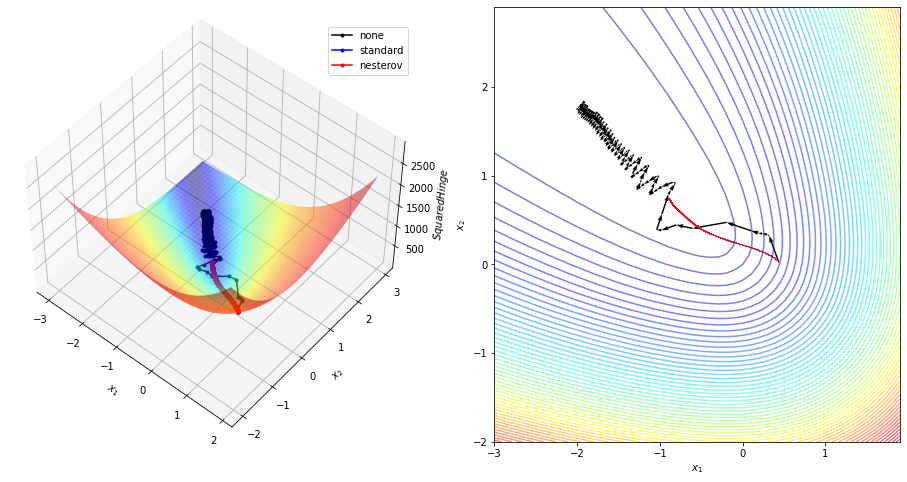

In [32]:
grid = GridSearchCV(PrimalSVC(loss=squared_hinge, optimizer=StochasticGradientDescent, learning_rate=0.001, 
                              momentum_type='nesterov', momentum=0.4, batch_size=20, early_stopping=True, 
                              random_state=2),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

squared_hinge_loss_opt = plot_trajectory_optimization(squared_hinge_loss_opt, grid.best_estimator_.optimizer, 
                                                      color='r', label='nesterov')
squared_hinge_loss_opt.savefig('./tex/img/svc_squared_hinge_loss.png')
squared_hinge_loss_opt

In [33]:
nesterov_primal_svc_squared_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
nesterov_primal_svc_squared_hinge_cv_results.insert(0, 'solver', 'sgd')
nesterov_primal_svc_squared_hinge_cv_results.insert(1, 'momentum', 'nesterov')
nesterov_primal_svc_squared_hinge_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
nesterov_primal_svc_squared_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                    
sgd    nesterov 1    0.172648      0.99     109    47
                10   0.126843      0.99      88    19
                100  0.037042      0.99      26    12

In [34]:
custom_primal_svc_squared_hinge_cv_results = none_primal_svc_squared_hinge_cv_results.append(
    standard_primal_svc_squared_hinge_cv_results).append(
    nesterov_primal_svc_squared_hinge_cv_results)
custom_primal_svc_squared_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                    
sgd    none     1    0.246589     0.990     163    50
                10   0.190085     0.990     139    19
                100  0.041115     0.995      29    14
       standard 1    0.164984     0.990     109    47
                10   0.124893     0.990      87    19
                100  0.038079     0.990      24    12
       nesterov 1    0.172648     0.990     109    47
                10   0.126843     0.990      88    19
                100  0.037042     0.990      26    12

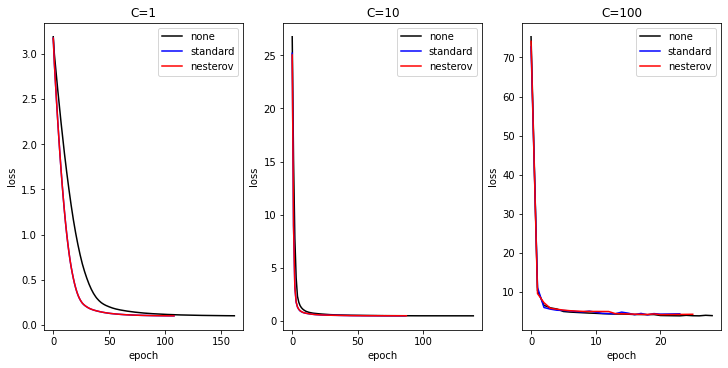

In [35]:
colors = {'none': 'k',
          'standard': 'b',
          'nesterov': 'r'}
axes = plt.figure(figsize=(10, 5), constrained_layout=True).subplots(1, 3)
for momentum, _dict in train_loss_history.items():
    for (C, history), loss in zip(_dict.items(), axes):
        loss.plot(history, color=colors[momentum])
        loss.set_title('C={:d}'.format(C))
        loss.set_xlabel('epoch')
        loss.set_ylabel('loss')
        loss.legend(colors.keys()).get_frame().set_facecolor('white')
plt.savefig('./tex/img/svc_squared_hinge_loss_history.png')

In [77]:
grid = GridSearchCV(SkLinearSVC(loss='squared_hinge', random_state=2),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

Fitting 1 folds for each of 3 candidates, totalling 3 fits


In [78]:
liblinear_primal_svc_squared_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_svc_squared_hinge_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_svc_squared_hinge_cv_results.insert(1, 'momentum', '-')
liblinear_primal_svc_squared_hinge_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
liblinear_primal_svc_squared_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver    momentum C                                    
liblinear -        1    0.009826      0.97     499    38
                   10   0.009072      0.97    1000    34
                   100  0.008421      0.97    1000    42

In [79]:
primal_svc_squared_hinge_cv_results = custom_primal_svc_squared_hinge_cv_results.append(liblinear_primal_svc_squared_hinge_cv_results)
primal_svc_squared_hinge_cv_results.to_latex('./tex/experiments/primal_svc_squared_hinge.tex', 
                                             caption='SVC Primal formulation results with Squared Hinge loss', 
                                             label='primal_svc_squared_hinge_cv_results', position='H')
primal_svc_squared_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver    momentum C                                    
sgd       none     1    0.255476     0.970     116    51
                   10   0.077421     0.970      27    33
                   100  0.049408     0.970      12    19
          standard 1    0.353654     0.965      83    49
                   10   0.117922     0.970      19    31
                   100  0.051094     0.970       8    18
          nesterov 1    0.305486     0.965      83    49
                   10   0.164126     0.970      25    30
                   100  0.062333     0.970      10    21
liblinear -        1    0.009826     0.970     499    38
                   10   0.009072     0.970    1000    34
                   100  0.008421     0.970    1000    42